In [1]:
import os
from glob import glob
import copy
from datetime import datetime
import distutils.dir_util
from shutil import copyfile
import ujson as json
import PIL


from matplotlib import pyplot as plt
%matplotlib inline
import bcolz
import numpy as np

from keras.utils.np_utils import to_categorical as one_hot

from keras.layers import Dense, Input, Lambda, BatchNormalization, Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Activation, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50, identity_block, conv_block
from keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.4


In [2]:
DATA_ROOT_DIR = "/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/"
TEST_STG1_DIR = DATA_ROOT_DIR + '/test_stg1/'
TEST_STG2_DIR = DATA_ROOT_DIR + '/test_stg2/'
RESULTS_DIR = DATA_ROOT_DIR + '/results/'

SAMPLE_ROOT_DIR = DATA_ROOT_DIR + "/sample/"
TRAIN_SAMPLE_DIR = SAMPLE_ROOT_DIR + '/train/'
VALID_SAMPLE_DIR = SAMPLE_ROOT_DIR + '/valid/'
TRAIN_DIR = DATA_ROOT_DIR + '/train/'
VALID_DIR = DATA_ROOT_DIR + '/valid/'

# 1. Prepare Data (create validation/sample sets, rearrange images by class dir)

Same as "the-nature-conservancy-fisheries-monitoring_v1-keras2.ipynb"

# 2. Finetune model on full data (not sample as small data)

In [3]:
def predict_generator_helper(model, batches, batch_size, num_batch_samples):
    # Be sure get_batches has used shuffle=False
    return model.predict_generator(batches,
                                   num_batch_samples // batch_size)
                                   #num_batch_samples)

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [3]:
# Create base model
resnet_base = ResNet50(include_top=False, weights='imagenet')

#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] # i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (1, 1, 2048)
classifier_input = Input(shape=classifier_input_shape)

### Precompute convolutional output (to save training time)

In [4]:
def preprocess_input(x, data_format=None):
    # Based on function at https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py
    # Altered for 3D input, assumes data_format='channels_last'
    
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 3D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

# Create (Raw Image) Batches
def get_batches(path,
                gen=ImageDataGenerator(preprocessing_function=preprocess_input),
                shuffle=True,
                batch_size=64,
                target_size=(224,224),
                class_mode='categorical'):
    return gen.flow_from_directory(path, 
                                   target_size=target_size,
                                   class_mode=class_mode,
                                   shuffle=shuffle, 
                                   batch_size=batch_size)

def create_precomputed_data(model, batches, batch_size):
    filenames = batches.filenames
    conv_features = predict_generator_helper(model, batches, batch_size, len(filenames))
    labels = one_hot(batches.classes)
    return (filenames, conv_features, labels)

def get_batch_data(batches):
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [ ]:
#batch_size = 32 # multiple of 2 and as large as you can (encourages more stable training), but no larger than 64.
trn_batch_size = 43 # ensure num_trn_sample/trn_batch_size is int.
val_batch_size = 38 # ensure num_val_sample/val_batch_size is int.
trn_batches = get_batches(TRAIN_DIR, batch_size=trn_batch_size, shuffle=False)
val_batches = get_batches(VALID_DIR, batch_size=val_batch_size, shuffle=False)

trn_filenames, trn_conv_features, trn_labels = create_precomputed_data(resnet_base, trn_batches, trn_batch_size)
val_filenames, val_conv_features, val_labels = create_precomputed_data(resnet_base, val_batches, val_batch_size)

num_trn_batch_samples, num_val_batch_samples = len(trn_filenames), len(val_filenames)

Found 3397 images belonging to 8 classes.
Found 380 images belonging to 8 classes.


In [4]:
%mkdir -p $RESULTS_DIR/ResNet50_conv_feats

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def save_precomputed_data(filenames, conv_feats, labels, features_base_name="ResNet50_conv_feats/trn_"):
    save_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat', np.array(filenames))
    save_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat', conv_feats)
    save_array(RESULTS_DIR+"/"+features_base_name+'labels.dat', np.array(labels))
    
save_precomputed_data(trn_filenames, trn_conv_features, trn_labels, "ResNet50_conv_feats/trn_")
save_precomputed_data(val_filenames, val_conv_features, val_labels, "ResNet50_conv_feats/val_")

NameError: name 'trn_filenames' is not defined

### Run finetuning

In [5]:
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="ResNet50_conv_feats/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels
                          
trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("ResNet50_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("ResNet50_conv_feats/val_")

In [6]:
assert len(trn_filenames) == 3397, "trn_filenames not as expected"
assert trn_conv_features.shape == (3397, 1, 1, 2048), "trn_conv_features not as expected"
assert trn_labels.shape == (3397, 8), "trn_labels not as expected"

assert len(val_filenames) == 380, "val_filenames not as expected"
assert val_conv_features.shape == (380, 1, 1, 2048), "val_conv_features not as expected"
assert val_labels.shape == (380, 8), "val_labels not as expected"

### Multi-Output

The images indicate that there is often a lot of noise in the images. Fortunately a kaggler has been through the training images and manually annotated the fish: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902

In [104]:
%cd $TRAIN_DIR
%mkdir manual_annotations
%cd manual_annotations
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147332/5471/other_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/158691/5864/NoF_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5459/shark_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5460/dol_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5461/yft_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5462/alb_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5463/lag_labels.json

--2017-05-12 13:42:33--  https://kaggle2.blob.core.windows.net/forum-message-attachments/158691/5864/NoF_labels.json
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.24
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333927 (326K) [application/json]
Saving to: ‘NoF_labels.json’

100%[======================================>] 333,927      914KB/s   in 0.4s   

2017-05-12 13:42:34 (914 KB/s) - ‘NoF_labels.json’ saved [333927/333927]

--2017-05-12 13:42:35--  https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.24
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82471 (81K) [application/json]
Saving to: 

In [7]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft', 'NoF']

LABELS_DIR = DATA_ROOT_DIR + "/manual_annotations"

bb_json = {}
for c in anno_classes:
    j = json.load(open(LABELS_DIR+'/{}_labels.json'.format(c), 'r'))
    for one_file in j:
        if 'annotations' in one_file.keys() and len(one_file['annotations'])>0:
            bb_json[one_file['filename'].split('/')[-1]] = sorted(
                one_file['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [8]:
# For any images that have no annotations, we'll create an empty bounding box.

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

print(len(bb_json))

raw_trn_filenames = [f.split("/")[-1] for f in trn_filenames]
raw_val_filenames = [f.split("/")[-1] for f in val_filenames]

for f in raw_trn_filenames:
    if f not in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
        
print(len(bb_json))
bb_json

3762
3777


{'img_06588.jpg': {'class': 'rect',
  'height': 185.0000000000009,
  'width': 420.00000000000193,
  'x': 624.0000000000031,
  'y': 576.0000000000028},
 'img_00886.jpg': {'class': 'rect',
  'height': 41.0,
  'width': 167.0,
  'x': 425.0,
  'y': 482.0},
 'img_05353.jpg': {'class': 'rect',
  'height': 169.20000000000104,
  'width': 139.59000000000094,
  'x': 688.0800000000041,
  'y': 242.5200000000015},
 'img_03582.jpg': {'class': 'rect',
  'height': 223.23763123631292,
  'width': 166.24078921853086,
  'x': 192.36434181001434,
  'y': 229.17480227983188},
 'img_02650.jpg': {'class': 'rect',
  'height': 296.1000000000001,
  'width': 180.48000000000002,
  'x': 572.4600000000002,
  'y': 78.96000000000002},
 'img_03434.jpg': {'class': 'rect',
  'height': 109.24394720074886,
  'width': 198.3015128535333,
  'x': 191.17690760131055,
  'y': 132.99263137482473},
 'img_05039.jpg': {'class': 'rect',
  'height': 173.36539447075515,
  'width': 201.8638154796464,
  'x': 299.2334205933582,
  'y': 225.612

In [9]:
# Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

bb_params = ['height', 'width', 'x', 'y']

def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

trn_sizes = [PIL.Image.open(TRAIN_DIR+f).size for f in trn_filenames]
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_trn_filenames, trn_sizes)], 
                   ).astype(np.float32)

val_sizes = [PIL.Image.open(VALID_DIR+f).size for f in val_filenames]
val_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, val_sizes)], 
                   ).astype(np.float32)

In [10]:
def to_plot(img):
    # Assumes tensorflow backend
    return np.rollaxis(img, 0, 1).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))

def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i, bbox, data):
    bb = bbox[i]
    plot(data[i])
    plt.gca().add_patch(create_rect(bb))
    
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size, gen=ImageDataGenerator())
    return np.concatenate([batches.next() for i in range(len(batches.filenames))])

trn_data = get_data(TRAIN_DIR)
val_data = get_data(VALID_DIR)

Found 3397 images belonging to 8 classes.
Found 380 images belonging to 8 classes.


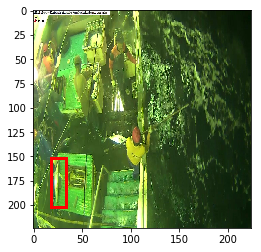

In [11]:
show_bb(0, trn_bbox, trn_data)

In [12]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.6

x = BatchNormalization()(classifier_input)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)
                                                     
resnet50_bb_v1 = Model([classifier_input], [x_bb, x_class])
resnet50_bb_v1.compile(Adam(lr=0.01), 
                    loss=['mse', 'categorical_crossentropy'],
                    metrics=['accuracy'], 
                    loss_weights=[.001, 1.])

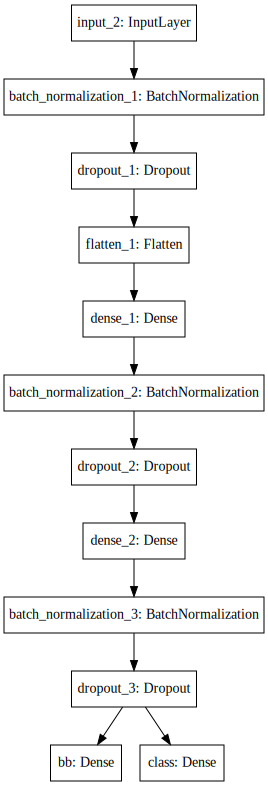

In [13]:
#from keras.utils import plot_model
#plot_model(resnet50_bb_v1, to_file='model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(resnet50_bb_v1).create(prog='dot', format='svg'))

In [13]:
def fit_precomputed_helper_multi_output(model, result_dir_name, batch_size=32, lr=0.1, nb_epoch=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit(trn_conv_features, [trn_bbox, trn_labels],
              batch_size=batch_size, 
              epochs=nb_epoch,
              validation_data=(val_conv_features, [val_bbox, val_labels]),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    #model.save_weights(results_dir + now)
    model.save(results_dir + "/model_" + now)
    return model

In [16]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_v1", lr=0.01, nb_epoch=5)
# Ran  times

Train on 3397 samples, validate on 380 samples
Epoch 1/5
3397/3397 [==============================] - 3s - loss: 0.7154 - bb_loss: 479.0361 - class_loss: 0.2364 - bb_acc: 0.7586 - class_acc: 0.9161 - val_loss: 0.5657 - val_bb_loss: 377.3024 - val_class_loss: 0.1884 - val_bb_acc: 0.8263 - val_class_acc: 0.9368

In [18]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_v1", lr=0.0001, nb_epoch=5)
# Ran  times

Train on 3397 samples, validate on 380 samples
Epoch 1/5
3397/3397 [==============================] - 3s - loss: 0.5538 - bb_loss: 423.6860 - class_loss: 0.1301 - bb_acc: 0.7677 - class_acc: 0.9547 - val_loss: 0.5261 - val_bb_loss: 364.5344 - val_class_loss: 0.1615 - val_bb_acc: 0.8263 - val_class_acc: 0.9684

In [19]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_v1", lr=0.000001, nb_epoch=5)
# Ran 1 time

Train on 3397 samples, validate on 380 samples
Epoch 1/5
3397/3397 [==============================] - 3s - loss: 0.5565 - bb_loss: 422.3461 - class_loss: 0.1342 - bb_acc: 0.7804 - class_acc: 0.9538 - val_loss: 0.5187 - val_bb_loss: 362.0072 - val_class_loss: 0.1567 - val_bb_acc: 0.8289 - val_class_acc: 0.9711

Much improved! Let's evaluate visually:

In [22]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val_data[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

In [23]:
pred = resnet50_bb_v1.predict(val_conv_features[0:10])

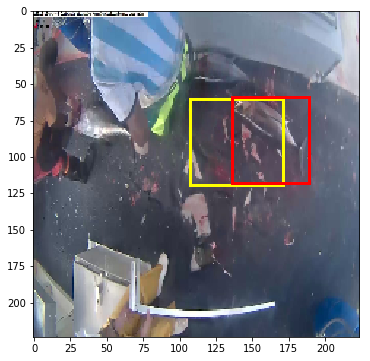

In [24]:
show_bb_pred(0)

### Pseudo Labelling

In [42]:
# Compute predictions on validation
val_pseudo = resnet50_bb_v1.predict(val_conv_features, batch_size=32)

assert val_pseudo[0].shape == (380, 4), "Expected val_pseudo to be a list with 1st element a np array of bbox predictions."
assert val_pseudo[1].shape == (380, 8), "Expected val_pseudo to be a list with 2nd element a np array of class predictions."

In [ ]:
def generate_arrays_from_file(path):
                while 1:
                    for line in f:
                        # create numpy arrays of input data
                        # and labels, from each line in the file
                        x1, x2, y = process_line(line)
                    yield (x, [y_bbox, y_labels])

In [ ]:
BAD:

In [ ]:
import importlib
importlib.reload(image)

In [43]:
val_batch_size = 38 #  ensure num_val_sample(i.e. 380)/val_batch_size is int.

import image # custom generator to add muli-output handling (based on http://stackoverflow.com/questions/38972380/keras-how-to-use-fit-generator-with-multiple-outputs-of-different-type)
custom_gen = image.ImageDataGenerator_custom() # preprocessing already performed when ran `get_batches(...)`

trn_batches = custom_gen.flow(trn_conv_features,
                              [trn_bbox, trn_labels],
                              batch_size=44,
                              shuffle=True)
val_pseudo_batches = custom_gen.flow(val_conv_features,
                                     val_pseudo,
                                     batch_size=val_pseudo_batch_size,
                                     shuffle=True)

val_batches = custom_gen.flow(val_conv_features,
                              [val_bbox, val_labels],
                              batch_size=val_batch_size,
                              shuffle=False)
#test_pseudo_batches = gen.flow()

In [48]:
mi_val_pseudo = MixIterator([val_pseudo_batches])#, test_batches])

In [49]:
resnet50_bb_v1.fit_generator(mi_val_pseudo, steps_per_epoch=10, epochs=1)

Epoch 1/1


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.4/threading.py", line 868, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
TypeError: 'MixIterator' object is not an iterator



ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

In [50]:
mi_val_pseudo.next()

TypeError: 'tuple' object is not an iterator

In [25]:
trn_batches.n

3397

In [26]:
val_pseudo_batches.next()[0].shape

(38, 1, 1, 2048)

TypeError: 'tuple' object is not an iterator

In [34]:
for o in [trn_batches,  val_pseudo_batches]:
    print(o)
    for it in o:
        next(it)

TypeError: 'tuple' object is not an iterator

In [ ]:
n0 = np.concatenate([n[0] for n in nexts])

In [ ]:
n1 = np.concatenate([n[1] for n in nexts])

In [ ]:
preprocess_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def fit_precomputed_helper_multi_output_pseudo(model, result_dir_name, batch_size=32, lr=0.1, epochs=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit_generator(mi_val_pseudo,
              steps_per_epoch=batch_size, 
              epochs=epochs,
              validation_data=(val_conv_features, [val_bbox, val_labels]),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    #model.save_weights(results_dir + now)
    model.save(results_dir + "/model_" + now)
    return model

In [85]:
resnet50_bb_v1 = fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

3777

In [ ]:
resnet50_bb_v1 = fit_precomputed_helper_multi_output(resnet50_bb_v1, "resnet50_bb_pseudo_v1", lr=0.001, epochs=5)
# Ran 1 time

## 3. Generate Test Predictions

In [31]:
def do_clip(arr, mx, num_classes): return np.clip(arr, (1-mx)/(num_classes-1), mx)

In [55]:
# Get Data
test_stg1_batches = get_batches(TEST_STG1_DIR, batch_size=1, shuffle=False)
test_stg2_batches = get_batches(TEST_STG2_DIR, batch_size=1, shuffle=False)

class_predictions = []

#for one_image in test_batches:
for _ in range(len(test_stg1_batches.filenames)):
    ##print(one_image[0].shape)
    #print(test_batches.next()[0].shape)
    one_image = test_stg1_batches.next()[0]
    
    test_conv_features = resnet_base.predict(one_image, batch_size=1)
    prediction = resnet50_bb_v1.predict(test_conv_features, batch_size=1)
    class_predictions.append(prediction[1])

#for one_image in test_batches:
for _ in range(len(test_stg2_batches.filenames)):
    ##print(one_image[0].shape)
    #print(test_batches.next()[0].shape)
    one_image = test_stg2_batches.next()[0]
    
    test_conv_features = resnet_base.predict(one_image, batch_size=1)
    prediction = resnet50_bb_v1.predict(test_conv_features, batch_size=1)
    class_predictions.append(prediction[1])
    
assert len(class_predictions) == 13153, "The number in of predictions created is not equal to the number in test_stg2"

Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.


In [56]:
preds = np.array(class_predictions)

subm = do_clip(preds, 0.82, 8)
subm_name = RESULTS_DIR+'resnet50_bb_v1/subm_bb.csv'
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [67]:
import pandas as pd

submission = pd.DataFrame(np.squeeze(subm), columns=classes)
submission.insert(0, 'image', test_stg1_batches.filenames + test_stg2_batches.filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,unknown/img_06681.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.052549
1,unknown/img_06893.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.149550
2,unknown/img_05393.jpg,0.025714,0.558379,0.025714,0.025714,0.025714,0.025714,0.025714,0.436121
3,unknown/img_01918.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,unknown/img_05568.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.084707


In [74]:
submission.tail()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
13148,unknown/image_02894.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
13149,unknown/image_09323.jpg,0.820000,0.025714,0.025714,0.025714,0.125225,0.025714,0.025714,0.025714
13150,unknown/image_04388.jpg,0.563699,0.025714,0.025714,0.025714,0.435546,0.025714,0.025714,0.025714
13151,unknown/image_09519.jpg,0.434750,0.068711,0.025714,0.025714,0.049612,0.028236,0.025714,0.418221
13152,unknown/image_11250.jpg,0.213110,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.780062


In [75]:
submission.to_csv(subm_name, index=False)#, header=False)#, compression='gzip')

In [81]:
subm_name_stg1 = RESULTS_DIR+'resnet50_bb_v1/subm_bb_test_stg1.csv'
subm_name_stg2 = RESULTS_DIR+'resnet50_bb_v1/subm_bb_test_stg2.csv'
subm_nameFIXED = RESULTS_DIR+'resnet50_bb_v1/subm_bbFIXED.csv'

!head -n +1001 $subm_name | sed "s:^unknown/::g" > $subm_name_stg1
!tail -n +1002 $subm_name | sed "s:^unknown:test_stg2:g" > $subm_name_stg2
!cat $subm_name_stg1 $subm_name_stg2 > $subm_nameFIXED

# 4 Visualise/Analyse validation predictions

In [97]:
See Kari - https://github.com/karijdempsey/learningWithKaggle/blob/master/1.0-kd-resnet_precomputedCNN_fisheries.ipynb

SyntaxError: invalid syntax (<ipython-input-97-713e8b2182a2>, line 1)